In [1]:
import os 

for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np
import pandas as pd

./input/titanic.zip
./input/gender_submission.csv
./input/test.csv
./input/train.csv
./input/titanic.zip:Zone.Identifier


In [2]:
train =pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
gender_submission = pd.read_csv('./input/gender_submission.csv')

In [3]:
data = pd.concat([train,test],sort = False)
data['Sex']=data['Sex'].replace(['male','female'],[0,1])
#male,femaleを０１に変換

/tmp/ipykernel_5384/3092714075.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sex']=data['Sex'].replace(['male','female'],[0,1])


In [4]:
data['Fare']=data['Fare'].fillna(np.mean(data['Fare']))
data['Embarked']= data['Embarked'].fillna('S').map({'S':0,'C':1,'Q':2}).astype(int)
age_ave = data['Age'].mean()
age_std = data['Age'].std()
data['Age'] = data['Age'].fillna(np.random.randint(age_ave - age_std,age_ave+ age_std))
#np.ranom.randint(a,b)はa以上b未満の整数をランダム生成
#data[].fillna(implace=True)みたいにやるのは古いのでdata[] = data[].fillnaにする

In [5]:
delete_columns = ['Name', 'PassengerId', 'Parch', 'Ticket', 'Cabin']
data = data.drop(delete_columns, axis=1)
#いらない特徴量を消す

In [6]:
train = data[:len(train)]
test = data[len(train):]
#行数で分離

In [7]:
y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)
#最終結果だけ分離

In [8]:
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train, y_train, test_size=0.3,
                                 random_state=0, stratify=y_train)
#/で改行[]の中ならなくてもよい
#訓練データと検証データに分離　test_size=0.3は3割を検証データにする
#stratify=y_trainはy_trainの生存と死亡の比率が分割後も同じになるよう調整する

In [9]:
categorical_features = ['Embarked', 'Pclass', 'Sex']
#カテゴリ変数だと宣言しないと連続数とみなされる。

In [11]:
import lightgbm as lgb

#lgb.Datasetで専用のデータセットを作成,カテゴリ変数を指定
lgb_train = lgb.Dataset(X_train, y_train,
                                         categorical_feature=categorical_features)
#reference= はlgb_trainと同じ前処理を適用するため
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train,
                                         categorical_feature=categorical_features)
#params(条件設定)、objective(目的関数)を'binary'（二値分類）に設定ほかにregressionなどもある
#max_bin(特徴量のビンの最大数,分割数)、learning_rate(学習率)通常0.1、num_leaves(決定木の葉の数)通常31
params = {
    'objective': 'binary',
    'max_bin': 300,
    'learning_rate': 0.05,
    'num_leaves': 40
}
# ログ出力と早期終了のための機能をインポート
from lightgbm import log_evaluation, early_stopping

# コールバック関数をリストにまとめる
#10回ごとにログを出力、10回連続で改善しなければ早期終了
callbacks = [
    log_evaluation(period=10),      # verbose_eval=10 の代わり
    early_stopping(stopping_rounds=10) # early_stopping_rounds=10 の代わり
]

# 学習の実行,valid_setsで評価データを指定,num_boost_roundで最大繰り返し回数を指定
model = lgb.train(
    params, 
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    num_boost_round=1000,
    callbacks=callbacks 
)
#num_iteration=model.best_iterationで一番精度の良い回数を指定
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [12]:
y_pred[:10]

array([0.04311822, 0.5313396 , 0.11201539, 0.103102  , 0.45465455,
       0.50251796, 0.67296118, 0.15515403, 0.71411015, 0.03951925])

In [13]:
y_pred = (y_pred > 0.5).astype(int)
y_pred[:10]

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [14]:
sub = pd.read_csv('./input/gender_submission.csv')
sub['Survived'] = y_pred
sub.to_csv('submission_lightgbm-2.csv', index=False)

sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

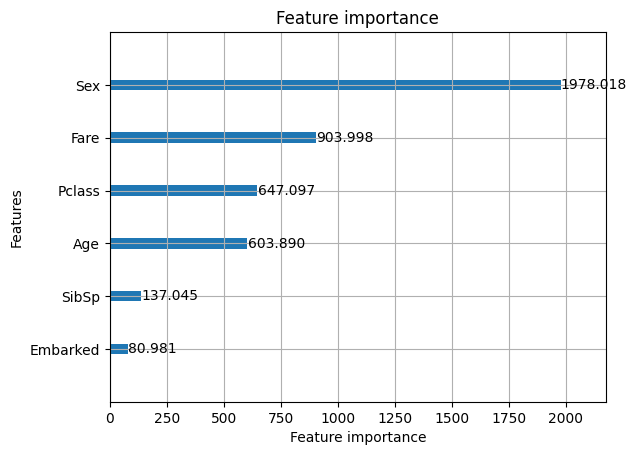

In [15]:
lgb.plot_importance(model, importance_type='gain')